### Question
Can a prediction be made using the written sentiment in the data with a neural models and NLP techniques?

### Objectives and Goals
The goal of this project is to train a neural network model that can accurately classify text reviews as positive or negative. The object is to automatically analyze customer reviews to provide the organization insights about their products.

### Prescribed Network
The type of neural network that will be used is a Sequential model with an Embedding layer, a GlobalAveragePooling1D layer. 

In [1]:
#import libaries and packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Dense
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
#import the three .txt files used for the model
amazon = pd.read_csv('/Users/dchoe/Desktop/D213/Task_2/amazon_cells_labelled.txt', sep='\t', header=None)
imdb = pd.read_csv('/Users/dchoe/Desktop/D213/Task_2/imdb_labelled.txt', sep='\t', header=None)
yelp = pd.read_csv('/Users/dchoe/Desktop/D213/Task_2/yelp_labelled.txt', sep='\t', header=None)


### Data Exploration

In [3]:
#explore the information in the datasets
amazon.info(), imdb.info(), yelp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       1000 non-null   object
 1   1       1000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 15.8+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       1000 non-null   object
 1   1       1000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 15.8+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       1000 non-null   object
 1   1       1000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 15.8+ KB


(None, None, None)

The three datasets have two series that are unnamed and each series has a 1000 observations. 

In [4]:
#review the first 5 rows of each dataset
amazon.head(), imdb.head(), yelp.head()

(                                                   0  1
 0  So there is no way for me to plug it in here i...  0
 1                        Good case, Excellent value.  1
 2                             Great for the jawbone.  1
 3  Tied to charger for conversations lasting more...  0
 4                                  The mic is great.  1,
                                                    0  1
 0  A very, very, very slow-moving, aimless movie ...  0
 1  Not sure who was more lost - the flat characte...  0
 2  Attempting artiness with black & white and cle...  0
 3       Very little music or anything to speak of.    0
 4  The best scene in the movie was when Gerardo i...  1,
                                                    0  1
 0                           Wow... Loved this place.  1
 1                                 Crust is not good.  0
 2          Not tasty and the texture was just nasty.  0
 3  Stopped by during the late May bank holiday of...  1
 4  The selection on the menu

In [5]:
#Name the columns of each dataset
amazon.columns = ['Review', 'Sentiment']
imdb.columns = ['Review', 'Sentiment']
yelp.columns = ['Review', 'Sentiment']

In [6]:
#review to see if the columns were properly named
amazon.info(), imdb.info(), yelp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Review     1000 non-null   object
 1   Sentiment  1000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 15.8+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Review     1000 non-null   object
 1   Sentiment  1000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 15.8+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Review     1000 non-null   object
 1   Sentiment  1000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 15.8+ KB


(None, None, None)

In [7]:
# Concatenate the datasets
df = pd.concat([amazon, imdb, yelp])

In [8]:
df.head()

,Review,Sentiment
0,So there is no way for me to plug it in here i...,0
1,"Good case, Excellent value.",1
2,Great for the jawbone.,1
3,Tied to charger for conversations lasting more...,0
4,The mic is great.,1


* Unusual Characters: The notebook includes a function to identify unusual characters in the text, such as emojis, non-English characters, etc. The function was applied to the 'Review' column of the dataset.

In [9]:
#function to detect for unusual text character
import unicodedata

def find_unusual_characters(text):
    unusual_chars = set()
    for char in text:
        char_name = unicodedata.name(char, '')
        if 'CJK UNIFIED' in char_name or 'EMOJI' in char_name or 'ARABIC' in char_name:
            unusual_chars.add(char)
    return unusual_chars

unusual_characters = set()
for review in df['Review']:
    unusual_characters.update(find_unusual_characters(review))

print(f'Found {len(unusual_characters)} unusual characters.')

Found 0 unusual characters.


* Vocabulary Size: The vocabulary size was calculated using the Tokenizer's word_index attribute.

In [10]:
#calculate vocabulary size
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['Review'])
vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index

print(f'Vocabulary size: {vocab_size}')

Vocabulary size: 5272


In [11]:
embedding_length = int(round(np.sqrt(np.sqrt(vocab_size)), 0))
embedding_length

9

* Word Embedding Length: The length of the word embeddings was calcuated as 9.
* Maximum Sequence Length: The maximum sequence length was calculated as the 95th percentile of the lengths of the reviews.

In [12]:
#calculate maximum sequence length
review_lengths = df['Review'].apply(lambda x: len(x.split()))
max_length = int(np.percentile(review_lengths, 95))  # 95th percentile

print(f'Maximum sequence length: {max_length}')

Maximum sequence length: 26


### Tokenization
The tokenization process was done using the Tokenizer from the TensorFlow Keras library. The goal of tokenization is to convert the text into sequences of integers, which can be used for the neural network model.

In [13]:
# Initialize and fit the tokenizer
tokenizer = Tokenizer(num_words=vocab_size, oov_token='<OOV>')
tokenizer.fit_on_texts(df['Review'])

# Convert text to sequences of integers
sequences = tokenizer.texts_to_sequences(df['Review'])

### Padding Process
The padding process was done using the pad_sequences function from the TensorFlow Keras library. The padding occurs after the text sequence. A single padded sequence is printed below.

In [14]:
# Pad sequences
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post', truncating='post')


In [15]:
#print single padded sequence
print(padded_sequences[0])

[  28   49    6   57  117   13   71    8  371    7   12   65   12    2
  187  579    4   76   61    5 2268    0    0    0    0    0]


### Categories of Sentiment
* There are two categories of sentiment: positive and negative. 
* The activation function for the final dense layer of the network is 'sigmoid'.

### Steps to Prepare the Data
Below are the steps used to prepare the data
- Imported datasets and performed EDA.
- Labeled the series in each dataset. 
- Combined the datasets using concat function.
- Detected for unusual text characters.
- Identified vocabulary size of the dataset.
- Calculated the maximum sequence length.
- Performed the tokenization and padding process.
- The data was split into training, validation, and test sets using a 80/10/10 split.

In [16]:
labels = np.array(df['Sentiment'])

In [17]:
# First, split the data into a training set and a temporary set using an 80/30 split
X_temp, X_test, y_temp, y_test = train_test_split(padded_sequences, labels, test_size=0.2, random_state=42)

# Then, split the temporary set into validation and test sets using a 50/50 split
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

### Prepared Dataset

In [18]:
#df.to_csv('/Users/dchoe/Desktop/D213/Task_2/df_cleaned.csv')

### Network Architecture
* The model has four layers: an Embedding layer, a GlobalAveragePooling1D layer, and two Dense layers. 
* The total number of parameters can be seen in the model summary below.
### Hyperparameters
* activation functions - The activation functions used are 'relu' and 'sigmoid'. The final activation function is a 'sigmoid' function because a sigmoid function is used to predict the probability of a binary variable.
* number of nodes per layer - the number of nodes per layer are 26 which was determined by the maximum sequence length, 50 was determined by trial and error, and 1 is the final layer of sigmoid because the use of binary variables. 
* loss function - the loss function is `binary_crossentropy`. This was used because it is a loss function used in binary classification problems.
* optimizer - The optimizer is 'adam'. This was used because it is straightforward and computationally efficient.
* stopping criteria - Validation Loss was used a the stopping criteria to prevent overfitting. Accuracy was  consistently above 90% after the 7th epoch in the training and was not a concern. 
* evaluation metric - The evaluation metric is 'accuracy' because the needs to be accurate to be useful. 

In [19]:
# Define the model
model = Sequential()
model.add(Embedding(vocab_size, embedding_length, input_length=max_length))  
model.add(GlobalAveragePooling1D())  
model.add(Dense(50, activation='relu'))  
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 26, 9)             47448     
                                                                 
 global_average_pooling1d (G  (None, 9)                0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 50)                500       
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 47,999
Trainable params: 47,999
Non-trainable params: 0
_________________________________________________________________


### Stopping Criteria
The use of stopping criteria prevents unnecessary computation after the model has stopped improving and will prevent overfitting. 

### Fit
The fitness of the model and any measures taken to address overfitting can be assessed by observing the plot of the training and validation accuracy and loss. After running the basic model and several trial and error proved that most models were overfitted. The model could be improved by using additional data. 

In [20]:
# Define early stopping criteria
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='auto')

# Train the model
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val), callbacks=[earlystop])

Epoch 1/50


2023-07-16 23:29:03.255404: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


38/38 [==============================] - 0s 3ms/step - loss: 0.6929 - accuracy: 0.5050 - val_loss: 0.6923 - val_accuracy: 0.5158
Epoch 2/50
38/38 [==============================] - 0s 1ms/step - loss: 0.6900 - accuracy: 0.6508 - val_loss: 0.6896 - val_accuracy: 0.7125
Epoch 3/50
38/38 [==============================] - 0s 1ms/step - loss: 0.6817 - accuracy: 0.8075 - val_loss: 0.6827 - val_accuracy: 0.7250
Epoch 4/50
38/38 [==============================] - 0s 1ms/step - loss: 0.6610 - accuracy: 0.8333 - val_loss: 0.6662 - val_accuracy: 0.7267
Epoch 5/50
38/38 [==============================] - 0s 1ms/step - loss: 0.6182 - accuracy: 0.8500 - val_loss: 0.6381 - val_accuracy: 0.6942
Epoch 6/50
38/38 [==============================] - 0s 1ms/step - loss: 0.5488 - accuracy: 0.8900 - val_loss: 0.5987 - val_accuracy: 0.7642
Epoch 7/50
38/38 [==============================] - 0s 1ms/step - loss: 0.4647 - accuracy: 0.9117 - val_loss: 0.5583 - val_accuracy: 0.7717
Epoch 8/50
38/38 [=============

### Predictive Accuracy
- The predictive accuracy is 82.16%.

In [21]:
# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f'Test set loss: {loss}')
print(f'Test set accuracy: {accuracy}')

Test set loss: 0.4481711685657501
Test set accuracy: 0.8216666579246521


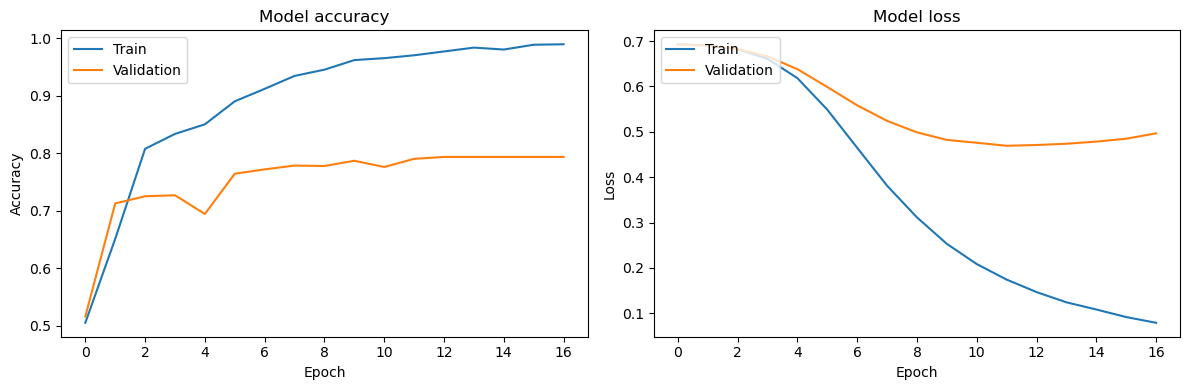

In [22]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [23]:
#save neural network
model.save('model.h5')

### Functionality

The functionality of this neural network is centered around sentiment analysis and predicts whether a  review text is positive or negative. It accomplishes this through learning patterns in the text dataset during training, then applying these patterns to make predictions. 

The architecture of a network is critical in how a model learns and makes predictions. This network's architecture comprises an Embedding layer, a `GlobalAveragePooling1D` layer, and two Dense layers `'relu'` and `'sigmoid'`. This architecture architecture is relatively simple but effective for binary text classification tasks.

### Recommendation

The model achieved 82.16% accuracy on the test set, indicating it could potentially be deployed for automatic sentiment classification. However continued updating of the dataset is recommended to preserve the accuracy and integrity of the model. 